# Sliced Evaluation and Fairness

In real-world machine learning, evaluating overall accuracy is not enough. Models may perform well on average but **struggle on specific subsets of the data**. Understanding these “slices” helps us:

- Identify weaknesses in the model  
- Detect potential biases  
- Make informed decisions about retraining or deployment  

In this notebook, we will:

1. Load the 5-flowers dataset using `tensorflow_datasets`.
2. Reuse a trained model (or train a lightweight one locally if needed).
3. Define **data slices** based on simple image properties, such as brightness.
4. Compute metrics per slice to observe performance differences.
5. Discuss implications for fairness and reliability.

By the end of this notebook, you will be able to **evaluate model performance on different subsets of data**, which is a critical step in building robust, production-ready computer vision systems.


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import os

# Load and Preprocess Dataset

# -----------------------------
# Important: IMG_SIZE must match the model's expected input.
# - If you are loading a saved model from a previous session, keep IMG_SIZE = 128 (since that's what it used)
# - If no saved model exists and a new model is trained, you can use IMG_SIZE = 224
# Changing this incorrectly will cause shape mismatch errors!
# -----------------------------
IMG_SIZE = 128
BATCH_SIZE = 32

(ds_train, ds_val), ds_info = tfds.load(
    "tf_flowers",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info=True
)

NUM_CLASSES = ds_info.features["label"].num_classes
CLASS_NAMES = ds_info.features["label"].names

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

ds_val = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [2]:
# Load Model (or Train Lightweight Model)

MODEL_PATH = "saved_model/flowers_model" #Update path to your saved model (or leave as-is to generate a new one)
# Example: MODEL_PATH = "..\\07_training\\model_registry\\v_20260215_185521\\" 
# --> ".." traverses one parent directory
# --> The double backslashes are needed on Windows (the first backslash protects the second from Python interpretation)

if os.path.exists(MODEL_PATH):
    model = tf.keras.models.load_model(MODEL_PATH)
    print("Loaded saved model.")
    if model.input_shape[1] != IMG_SIZE:
        print(f"⚠️ Warning: Model expects input size {model.input_shape[1]}x{model.input_shape[2]}, "
              f"but IMG_SIZE is set to {IMG_SIZE}. Resize in preprocessing accordingly!")
else:
    print("Saved model not found. Training a lightweight model for demo...")
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    ds_train = ds_train.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    model.fit(ds_train, epochs=1)


Saved model not found. Training a lightweight model for demo...
92/92 [==============================] - 10s 76ms/step - loss: 0.7931 - accuracy: 0.7027


In [3]:
# Define a Data Slice
# We’ll use image brightness as a simple example. This is easy to compute and shows the concept of slicing.

def brightness_level(image):
    return tf.reduce_mean(image)

bright_threshold = 0.5  # images with average pixel > 0.5 are “bright”


In [4]:
# Evaluate Model Per Slice

bright_preds = []
bright_labels = []
dark_preds = []
dark_labels = []

for images, labels in ds_val:
    preds = model.predict(images, verbose=0)
    preds = np.argmax(preds, axis=1)
    images_np = images.numpy()
    labels_np = labels.numpy()

    for i in range(len(labels_np)):
        if brightness_level(images_np[i]) > bright_threshold:
            bright_preds.append(preds[i])
            bright_labels.append(labels_np[i])
        else:
            dark_preds.append(preds[i])
            dark_labels.append(labels_np[i])

print(f"Bright slice: {len(bright_labels)} examples")
print(f"Dark slice: {len(dark_labels)} examples")


Bright slice: 137 examples
Dark slice: 597 examples


In [5]:
# Compute Accuracy per Slice

def compute_accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(y_true == y_pred)

print("Bright images accuracy:", compute_accuracy(bright_labels, bright_preds))
print("Dark images accuracy:", compute_accuracy(dark_labels, dark_preds))


Bright images accuracy: 0.7664233576642335
Dark images accuracy: 0.8408710217755444


1/1 [==============================] - 0s 83ms/step


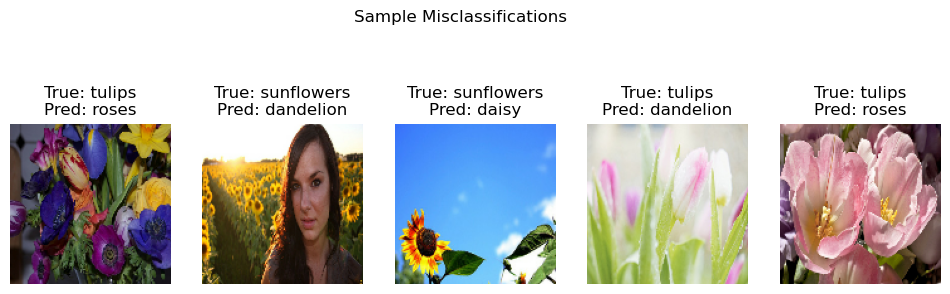

1/1 [==============================] - 0s 78ms/step


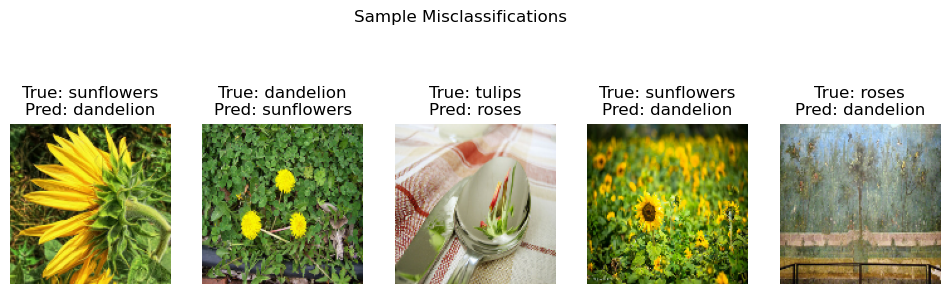

1/1 [==============================] - 0s 62ms/step


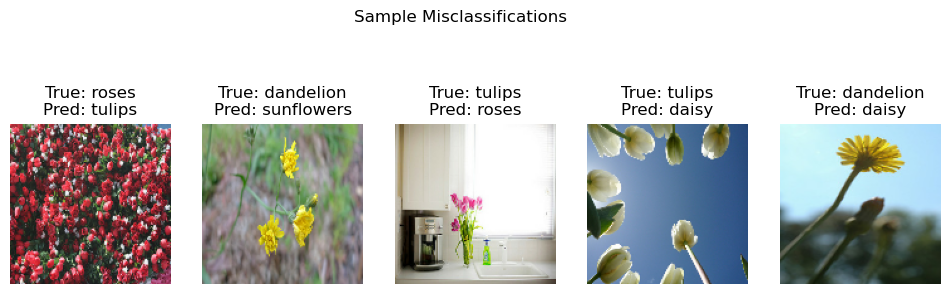

In [6]:
# Visualize Example Slices

def plot_examples(images, labels, preds, class_names, title):
    plt.figure(figsize=(12,4))
    count = 0
    for i in range(len(images)):
        if count >= 5:
            break
        if labels[i] != preds[i]:
            plt.subplot(1,5,count+1)
            plt.imshow(images[i])
            plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
            plt.axis('off')
            count += 1
    plt.suptitle(title)
    plt.show()

# Convert first 3 batches to numpy for plotting
for images, labels in ds_val.take(3):
    images_np = images.numpy()
    labels_np = labels.numpy()
    preds = np.argmax(model.predict(images_np), axis=1)
    plot_examples(images_np, labels_np, preds, CLASS_NAMES, "Sample Misclassifications")


1/1 [==============================] - 0s 85ms/step


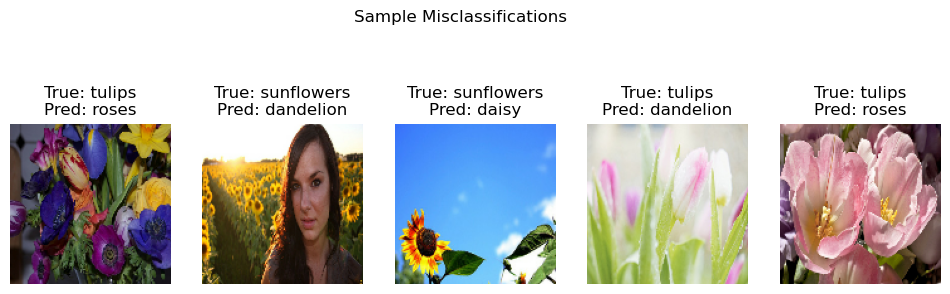

1/1 [==============================] - 0s 79ms/step


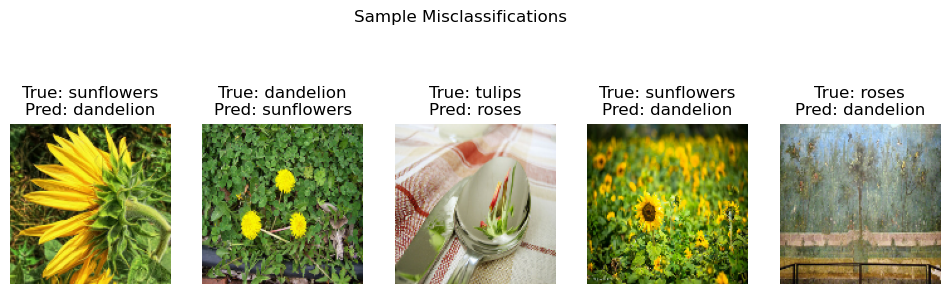

1/1 [==============================] - 0s 86ms/step


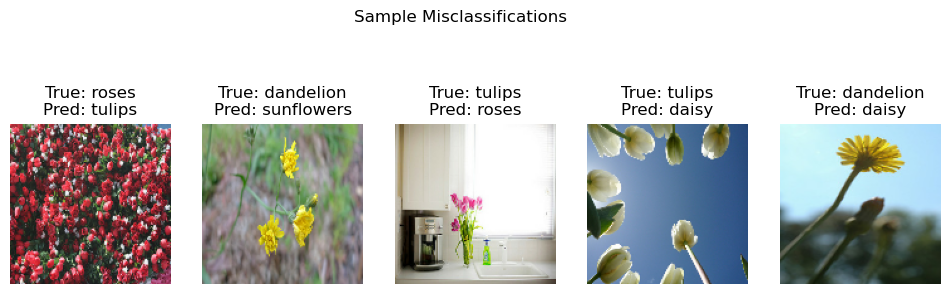

Total misclassified images in first 3 batches: 19


In [7]:
# Track total misclassifications across batches

total_misclassified = 0
for images, labels in ds_val.take(3):
    images_np = images.numpy()
    labels_np = labels.numpy()
    preds = np.argmax(model.predict(images_np), axis=1)
    
    misclassified_count = sum(labels_np[i] != preds[i] for i in range(len(labels_np)))
    total_misclassified += misclassified_count
    
    plot_examples(images_np, labels_np, preds, CLASS_NAMES, "Sample Misclassifications")

print(f"Total misclassified images in first 3 batches: {total_misclassified}")


## Notes
- This example uses brightness as a simple slice, but slices could be based on:
  - Image resolution or size
  - Color dominance
  - Background complexity
  - Any metadata if available
- Observing performance per slice helps detect biases, weaknesses, or edge cases.
- This lays the groundwork for fairness analysis and monitoring in production (covered in 08d).